# Random Forest and XGBoost model development and evaluation
In this final notebook, we will develop and evaluate ensemble-based machine learning models—Random Forest and XGBoost—to classify colorectal tumors based on their potential metastatic behavior. As mentioned before, the models aim to distinguish between stage III–IV tumors, which have likely released metastatic cells, and stage I–II tumors, which have not.

Ensemble models combine the predictive power of multiple base learners to produce more robust and accurate predictions. Compared to traditional classifiers, they are often more resistant to overfitting and better at capturing complex, non-linear relationships in the data. This makes them especially valuable in biomedical applications where signal-to-noise ratios can be low and interactions between features are subtle.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import uniform, randint

In [ ]:
# Defining the confusion matrix plotting function
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Stage I-II', 'Stage III-IV']); ax.yaxis.set_ticklabels(['Stage I-II', 'Stages III-IV'])
    plt.show()

In [ ]:
# Reading the capped df (can be anyone of the previously obtained)
df_mir_expression = pd.read_csv('df_mir_new_capped.csv', index_col='File_ID')
df_mir_expression.head()

,hsa-mir-29a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-145,hsa-mir-149,hsa-mir-1246,hsa-mir-4488,hsa-mir-492,hsa-mir-200a,hsa-mir-338,...,hsa-mir-218-2,hsa-mir-429,Stages_encoded,gender,30-40,40-50,50-60,60-70,70-80,80-90
File_ID,,,,,,,,,,,,,,,,,,,,,
3cd62167-7962-44ea-8923-6e9c7fc97807.mirbase21.isoforms.quantification.txt,6433.475,96.445,100.829,2455.026,3.705,0.000,0.0,0.062,1066.082,147.755,...,8.274,174.243,0.0,0,0,0,0,0,1,0
ef4cd175-6f73-4360-b2c6-71b424d64f53.mirbase21.isoforms.quantification.txt,6301.933,79.897,79.763,1111.711,5.908,0.269,0.0,0.000,2083.501,975.416,...,1.611,321.468,0.0,0,0,0,1,0,0,0
98694eb1-1282-4426-8fb2-001ac8190323.mirbase21.isoforms.quantification.txt,5633.066,87.079,91.507,2537.585,1.968,0.492,0.0,0.492,3693.225,139.720,...,3.444,573.146,0.0,0,0,0,0,1,0,0
a6f1d4ee-b216-4b96-95a6-5705662254d7.mirbase21.isoforms.quantification.txt,17290.156,151.468,158.526,3408.302,54.561,0.000,0.0,0.000,3575.242,388.714,...,6.515,585.513,0.0,0,0,0,0,0,1,0
e3f4c57a-45e8-4dd6-96b1-e12ba2bdb415.mirbase21.isoforms.quantification.txt,9060.427,85.355,81.798,1135.932,4.268,0.000,0.0,0.000,2634.623,522.088,...,4.979,233.304,0.0,1,0,0,0,0,1,0


# Data pre-processing

In [ ]:
# Assigning columns to the X and y variables
y = df_mir_expression['Stages_encoded'].to_numpy()
X = df_mir_expression.drop('Stages_encoded', axis=1)
# Standarizing the miRNA expression features
st = StandardScaler()
X = st.fit_transform(X)

In [ ]:
# Dividing into test and train sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest and XGBoost model building

In [ ]:
# Building the XGBoost model object
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# Establishing the distribution of hyperparameters where the search will be done
param_dist = param_dist = {'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.4)
}
# Random search of hyperparameters
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=20, scoring='accuracy',
    cv=5, random_state=42
)
# Training the XGBoost model
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:54:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:54:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:54:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:54:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:54:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d080072ac90>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d0800729a90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d080072abd0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d0800669c50>},
                   random_state=42, scoring='accuracy')

In [ ]:
# Building the Random Forest model object
rf = RandomForestClassifier(random_state=42)
# Building the feature selector
k_best = SelectKBest(mutual_info_classif)
# Creating the pipeline object
pipe = Pipeline([('sk', k_best), ('rf', rf)])
# Establishing parameters for the hyperparameter grid search
param_grid = {'sk__k':[5, 10, 15, 20],
    'rf__n_estimators': [60, 80, 100, 200],
    'rf__max_depth': [None, 10, 15, 20],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_split': [2, 5]
}
# Grid search
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sk',
                                        SelectKBest(score_func=<function mutual_info_classif at 0x7d0816d6d620>)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 15, 20],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [60, 80, 100, 200],
                         'sk__k': [5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

#Model Evaluation

In [ ]:
# Evaluating best parameters from the hyperparameter grid and randomized search and orinting the classification report to understand mistakes distribution
print("Random Forest Best parameters:", grid_search.best_params_)
print("Random Forest Classification Report:\n", classification_report(y_test, grid_search.predict(X_test)))
print('')
print("XGBoost Best parameters:", random_search.best_params_)
print("XGBoost Classification Report:\n", classification_report(y_test, random_search.predict(X_test)))

Random Forest Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'sk__k': 15}
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.54      0.60      0.56        99
         1.0       0.38      0.32      0.35        75

    accuracy                           0.48       174
   macro avg       0.46      0.46      0.45       174
weighted avg       0.47      0.48      0.47       174


XGBoost Best parameters: {'colsample_bytree': np.float64(0.8918424713352255), 'gamma': np.float64(0.25502298854208527), 'learning_rate': np.float64(0.27616382277289797), 'max_depth': 3, 'n_estimators': 200, 'subsample': np.float64(0.9886848381556415)}
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.56      0.52      0.54        99
         1.0       0.42      0.47      0.44        75

    accuracy                         

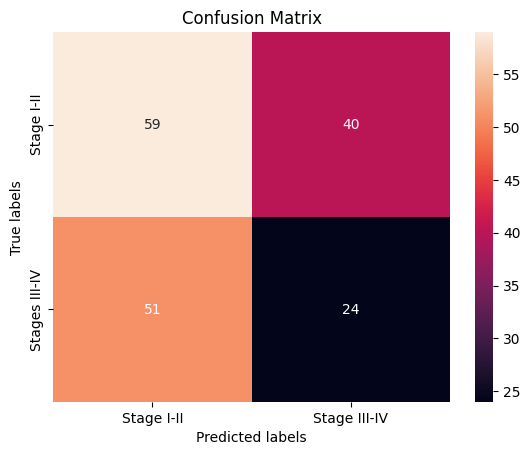

In [ ]:
# Plot the confusion matrix of the Random Forest model to visualize the mistakes distribution
yhat_rf = grid_search.predict(X_test)
plot_confusion_matrix(y_test, yhat_rf)

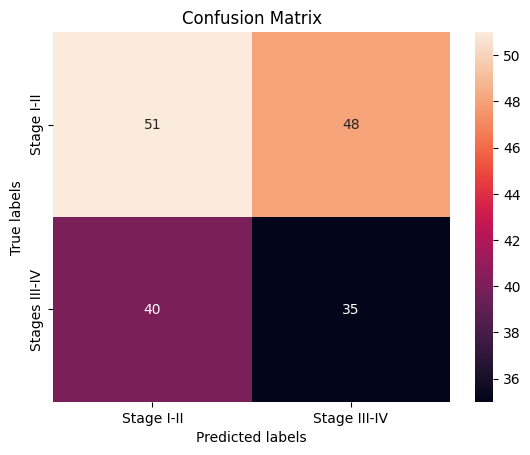

In [ ]:
# Plot the confusion matrix of the XGBoost model to visualize the mistakes distribution
yhat_XGB = random_search.predict(X_test)
plot_confusion_matrix(y_test, yhat_XGB)

# Classification report metrics: Recall
What we are trying to predict is whether a patient carries a stage I-II or stage III-IV tumor since the latest is more dangerous. The key metric when addressing this is recall, because is the rate between true positives and actual positives. A false negative in this context, true stage III-IV but classified as stage I-II, would imply a threat to a patient's life.

In [ ]:
print('XGB Accuracy:', accuracy_score(y_test, yhat_XGB))
print('RF Accuracy:', accuracy_score(y_test, yhat_rf))

XGB Accuracy: 0.4942528735632184
RF Accuracy: 0.47701149425287354


# Overfitting o Underfitting model analysis:
We can address whether the models are overfitted or underfitted by checking all the metrics using the training data subset. This way we can think about subsequent steps for improving accuracy.

In [ ]:
# Make predictions using the training sub set
yhat_rf_train = grid_search.predict(X_train)
yhat_XGB_train = random_search.predict(X_train)

In [ ]:
# Check the accuracy on the model's predictions using the y training sub set
print('Random Forest training accuracy:', accuracy_score(y_train, yhat_rf_train))
print('XGB training accuracy:', accuracy_score(y_train, yhat_XGB_train))

Random Forest training accuracy: 1.0
XGB training accuracy: 1.0


In [ ]:
# Finally, we evaluate the different types of mistakes done using the training sub set to make predictions
print('Random Forest training metrics')
print(classification_report(y_train, yhat_rf_train))
print('XGB training metrics')
print(classification_report(y_train, yhat_XGB_train))

Random Forest training metrics
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       213
         1.0       1.00      1.00      1.00       192

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405

XGB training metrics
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       213
         1.0       1.00      1.00      1.00       192

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405



#Project Conclusion:
This project set out to develop a machine learning model capable of predicting the metastatic potential of colorectal tumors—specifically distinguishing between pathological stages I–II (non-metastatic) and III–IV (metastatic)—based solely on miRNA expression profiles. The motivation lies in the growing evidence that specific miRNAs play critical roles in cancer progression, including the regulation of epithelial–mesenchymal transition (EMT), which is closely linked to metastasis.

To achieve this goal, the project followed a structured pipeline:

##Data Collection:
Expression data of selected miRNAs related to tumor progression and EMT was retrieved from the NIH’s Genome Data Commons (GDC), using publicly available transcriptome profiles.

##Data Wrangling:
The datasets were preprocessed to handle missing values and unified into a single, analysis-ready DataFrame. Additional miRNAs associated with E-cadherin deregulation were incorporated to enrich the feature space.

##Exploratory Data Analysis (EDA):
Initial analyses helped uncover patterns, feature distributions, and potential outliers in both the original and newly added miRNA features.

##Outlier Handling:
Several methods were implemented to improve data quality, including IQR-based filtering, Isolation Forest, DBSCAN, One-Class SVM, and capping-based transformations.

##Model Development and Evaluation:

Baseline models (Logistic Regression, Support Vector Machines, and k-Nearest Neighbors) were trained using different outlier-handled datasets.

Feature selection and transformations were applied to improve classifier performance.

##Hyperparameter tuning and cross-validation ensured better model generalization.

Ensemble models (Random Forest and XGBoost) were then implemented, leveraging their robustness and superior performance in complex classification tasks.

Despite the steps taken, model accuracy didn't reach expected levels. This highlights a limitation in relying solely on molecular features. For future improvement, incorporating clinical variables (e.g., tumor grade, patient demographics, sex) alongside miRNA data is essential to build a more comprehensive and predictive model.

